## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-09-29 16:09:49.267772: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 16:09:50.078305: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-29 16:09:50.515618: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-29 16:09:50.516945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)
importlib.reload(data.data_load)


<module 'data.data_load' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_load.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 5.9%
RAM Usage: 3.9%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [7]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Simulation tests <a id="sims"></a>

In [53]:
# Load all gene lists and print sizes
gene_lists = ['0.2', '1', 'brain', 'neuron', 'oligodendrocyte', 'synaptome', 'layers', 'richiardi2015', 'syngo', 'all_abagen', 'lake_shared']

for gene_list in gene_lists:
    print(f"\nLoading gene list: {gene_list}")
    try:
        X, valid_genes = load_transcriptome(parcellation='S456', gene_list=gene_list, sort_genes='refgenome', return_valid_genes=True)
        print(f"Number of genes: {len(valid_genes)}")
    except Exception as e:
        print(f"Error loading {gene_list}: {str(e)}")



Loading gene list: 0.2
Number of genes: 7380

Loading gene list: 1
Number of genes: 15633

Loading gene list: brain
Number of genes: 1879

Loading gene list: neuron
Number of genes: 2291

Loading gene list: oligodendrocyte
Number of genes: 1591

Loading gene list: synaptome
Number of genes: 1718

Loading gene list: layers
Number of genes: 42

Loading gene list: richiardi2015
Number of genes: 105

Loading gene list: syngo
Number of genes: 1504

Loading gene list: all_abagen
Number of genes: 5394

Loading gene list: lake_shared
Number of genes: 582


In [46]:
from data.data_load import load_transcriptome

X, valid_genes_random = load_transcriptome(parcellation='S456', gene_list='0.2', sort_genes='random', return_valid_genes=True)
X, valid_genes_ref = load_transcriptome(parcellation='S456', gene_list='0.2', sort_genes='refgenome', return_valid_genes=True)
X, valid_genes_exp = load_transcriptome(parcellation='S456', gene_list='0.2', sort_genes='expression', return_valid_genes=True)

# Get gene2vec embeddings for all genes
gene_emb_df = pd.read_csv('/scratch/asr655/neuroinformatics/GeneEx2Conn/data/gene_emb/gene2vec_dim_200_iter_9.txt',
                         sep='\s+',
                         header=None,
                         index_col=0)

# Convert valid_genes_ref to set for intersection
valid_genes_ref_set = set(valid_genes_ref)
overlap_genes = list(valid_genes_ref_set.intersection(gene_emb_df.index))

# Get indices of overlapping genes for each sorting method
random_idx = [list(valid_genes_random).index(gene) for gene in overlap_genes]
ref_idx = [list(valid_genes_ref).index(gene) for gene in overlap_genes] 
exp_idx = [list(valid_genes_exp).index(gene) for gene in overlap_genes]

# Verify indices are unique and same length
print("Number of unique indices:")
print(f"Random sorting: {len(set(random_idx))} out of {len(random_idx)}")
print(f"Reference genome sorting: {len(set(ref_idx))} out of {len(ref_idx)}")
print(f"Expression sorting: {len(set(exp_idx))} out of {len(exp_idx)}")

# Get embeddings for overlapping genes in original gene_emb_df order
gene_emb = gene_emb_df.reindex(overlap_genes).values




  sep='\s+',



Number of unique indices:
Random sorting: 6957 out of 6957
Reference genome sorting: 6957 out of 6957
Expression sorting: 6957 out of 6957


In [47]:
# Get reference genome info for all genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')
refgenome = refgenome.drop_duplicates(subset='gene_id', keep='first')

# Print unique chromosome names
print("Unique chromosomes:")
print(sorted(refgenome['chromosome'].unique()))

Unique chromosomes:
['NC_000001.11', 'NC_000002.12', 'NC_000003.12', 'NC_000004.12', 'NC_000005.10', 'NC_000006.12', 'NC_000007.14', 'NC_000008.11', 'NC_000009.12', 'NC_000010.11', 'NC_000011.10', 'NC_000012.12', 'NC_000013.11', 'NC_000014.9', 'NC_000015.10', 'NC_000016.10', 'NC_000017.11', 'NC_000018.10', 'NC_000019.10', 'NC_000020.11', 'NC_000021.9', 'NC_000022.11', 'NC_000023.11', 'NC_000024.10', 'NC_012920.1', 'NT_113793.3', 'NT_113796.3', 'NT_113888.1', 'NT_113889.1', 'NT_113891.3', 'NT_113901.1', 'NT_113930.2', 'NT_113949.2', 'NT_167208.1', 'NT_167209.1', 'NT_167211.2', 'NT_167213.1', 'NT_167214.1', 'NT_167215.1', 'NT_167218.1', 'NT_167219.1', 'NT_167244.2', 'NT_167245.2', 'NT_167246.2', 'NT_167247.2', 'NT_167248.2', 'NT_167249.2', 'NT_167250.2', 'NT_167251.2', 'NT_187361.1', 'NT_187363.1', 'NT_187366.1', 'NT_187367.1', 'NT_187368.1', 'NT_187369.1', 'NT_187373.1', 'NT_187374.1', 'NT_187375.1', 'NT_187377.1', 'NT_187378.1', 'NT_187379.1', 'NT_187380.1', 'NT_187381.1', 'NT_187382.1

In [48]:
# Get chromosome labels for each gene in overlap_genes
gene_chromosomes = list(refgenome.set_index('gene_id').loc[overlap_genes, 'chromosome'].values)

# Define valid chromosome categories
valid_chromosomes = ['NC_000001.11', 'NC_000002.12', 'NC_000003.12', 'NC_000004.12', 
                    'NC_000005.10', 'NC_000006.12', 'NC_000007.14', 'NC_000008.11',
                    'NC_000009.12', 'NC_000010.11', 'NC_000011.10', 'NC_000012.12', 
                    'NC_000013.11', 'NC_000014.9', 'NC_000015.10', 'NC_000016.10',
                    'NC_000017.11', 'NC_000018.10', 'NC_000019.10', 'NC_000020.11',
                    'NC_000021.9', 'NC_000022.11', 'NC_000023.11', 'NC_000024.10']

# Convert chromosomes to numerical categories with 'other' category
chromosome_to_num = {chrom: i for i, chrom in enumerate(valid_chromosomes)}
chromosome_to_num['other'] = len(valid_chromosomes)  # Add 'other' category

gene_chromosomes_num = []
for chrom in gene_chromosomes:
    if chrom in valid_chromosomes:
        gene_chromosomes_num.append(chromosome_to_num[chrom])
    else:
        gene_chromosomes_num.append(chromosome_to_num['other'])

print(f"Shape of numerical chromosome array: {len(gene_chromosomes_num)}")


Shape of numerical chromosome array: 6957


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f68ecb64180>
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/ext3/miniconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ext3/miniconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/ext3/miniconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


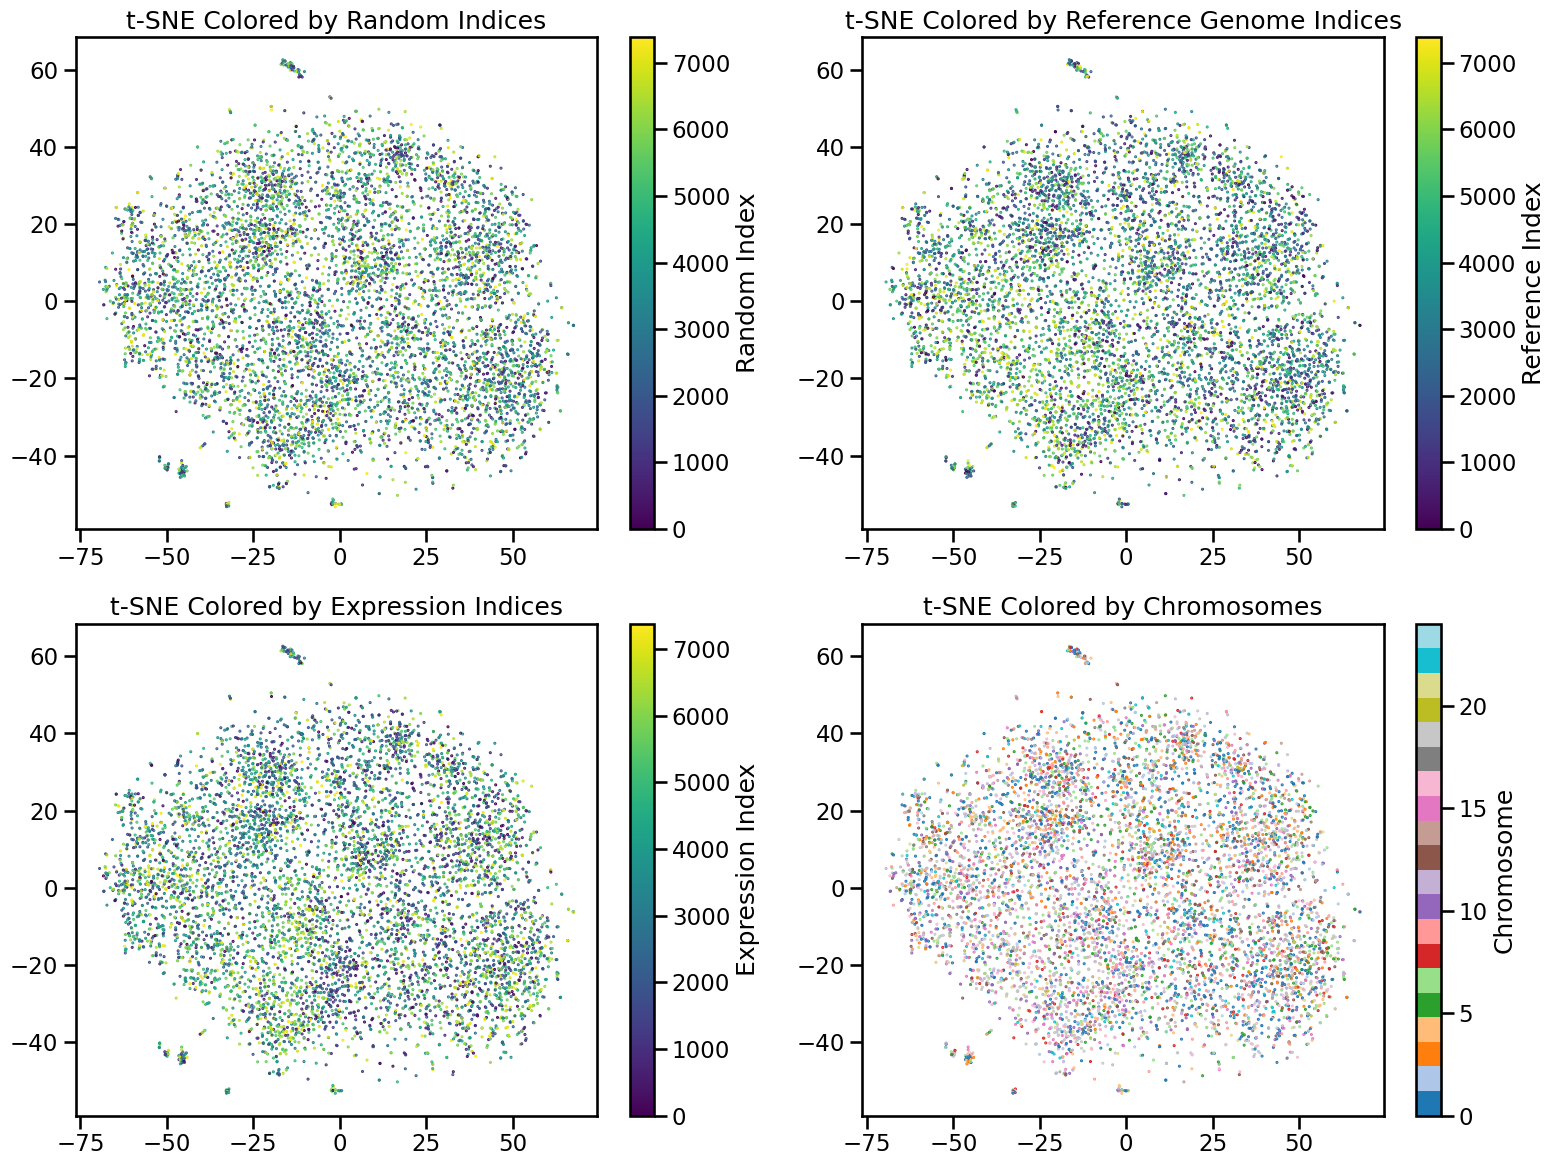

In [49]:
# Import required libraries
from sklearn.manifold import TSNE

# Create t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(gene_emb)

# Create figure with 4 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot colored by random indices
scatter1 = ax1.scatter(tsne_results[:, 0], tsne_results[:, 1], s=0.5,
                      c=random_idx, cmap='viridis')
ax1.set_title('t-SNE Colored by Random Indices')
plt.colorbar(scatter1, ax=ax1, label='Random Index')

# Plot colored by reference genome indices  
scatter2 = ax2.scatter(tsne_results[:, 0], tsne_results[:, 1], s=0.5,
                      c=ref_idx, cmap='viridis')
ax2.set_title('t-SNE Colored by Reference Genome Indices')
plt.colorbar(scatter2, ax=ax2, label='Reference Index')

# Plot colored by expression indices
scatter3 = ax3.scatter(tsne_results[:, 0], tsne_results[:, 1], s=0.5,
                      c=exp_idx, cmap='viridis')
ax3.set_title('t-SNE Colored by Expression Indices')
plt.colorbar(scatter3, ax=ax3, label='Expression Index')

# Plot colored by chromosome numbers
scatter4 = ax4.scatter(tsne_results[:, 0], tsne_results[:, 1], s=0.5,
                      c=gene_chromosomes_num, cmap='tab20')
ax4.set_title('t-SNE Colored by Chromosomes')
plt.colorbar(scatter4, ax=ax4, label='Chromosome')

plt.tight_layout()
plt.show()


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



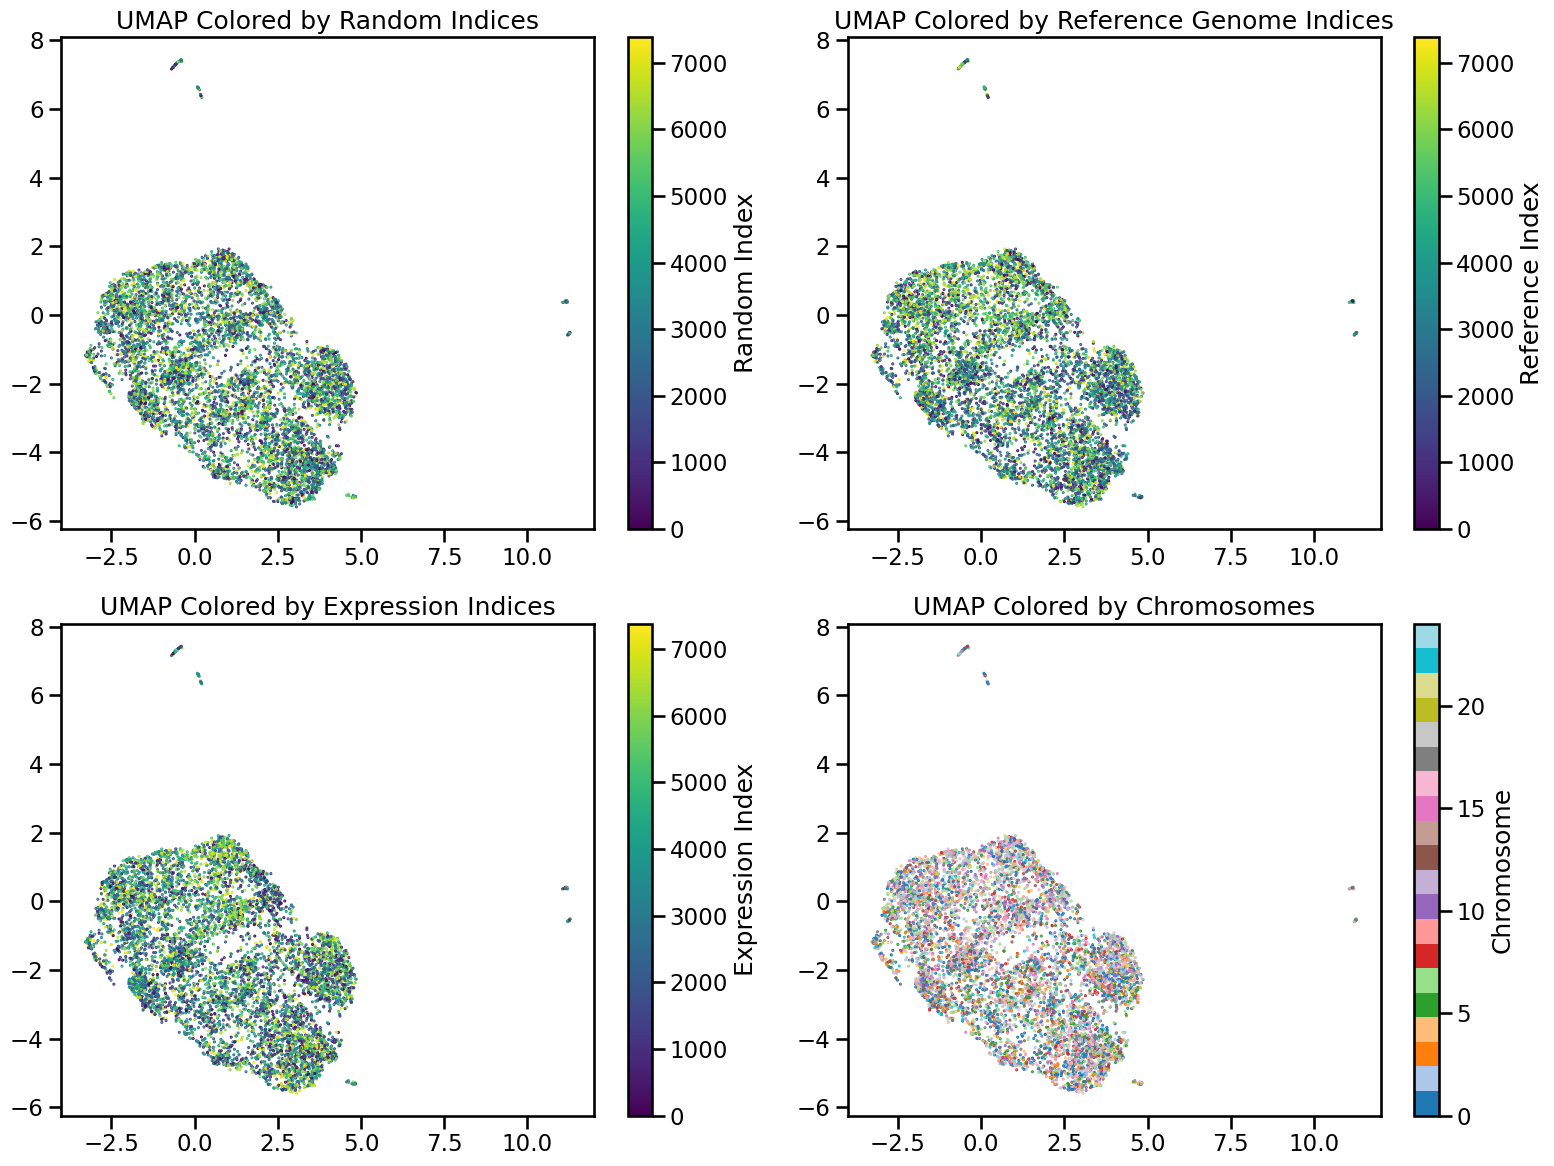

In [50]:
# Import required libraries
from umap import UMAP

# Create UMAP embeddings
umap = UMAP(n_components=2, random_state=42)
umap_results = umap.fit_transform(gene_emb)

# Create figure with 4 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot colored by random indices
scatter1 = ax1.scatter(umap_results[:, 0], umap_results[:, 1], s=0.5,
                      c=random_idx, cmap='viridis')
ax1.set_title('UMAP Colored by Random Indices')
plt.colorbar(scatter1, ax=ax1, label='Random Index')

# Plot colored by reference genome indices  
scatter2 = ax2.scatter(umap_results[:, 0], umap_results[:, 1], s=0.5,
                      c=ref_idx, cmap='viridis')
ax2.set_title('UMAP Colored by Reference Genome Indices')
plt.colorbar(scatter2, ax=ax2, label='Reference Index')

# Plot colored by expression indices
scatter3 = ax3.scatter(umap_results[:, 0], umap_results[:, 1], s=0.5,
                      c=exp_idx, cmap='viridis')
ax3.set_title('UMAP Colored by Expression Indices')
plt.colorbar(scatter3, ax=ax3, label='Expression Index')

# Plot colored by chromosome numbers
scatter4 = ax4.scatter(umap_results[:, 0], umap_results[:, 1], s=0.5,
                      c=gene_chromosomes_num, cmap='tab20')
ax4.set_title('UMAP Colored by Chromosomes')
plt.colorbar(scatter4, ax=ax4, label='Chromosome')

plt.tight_layout()
plt.show()


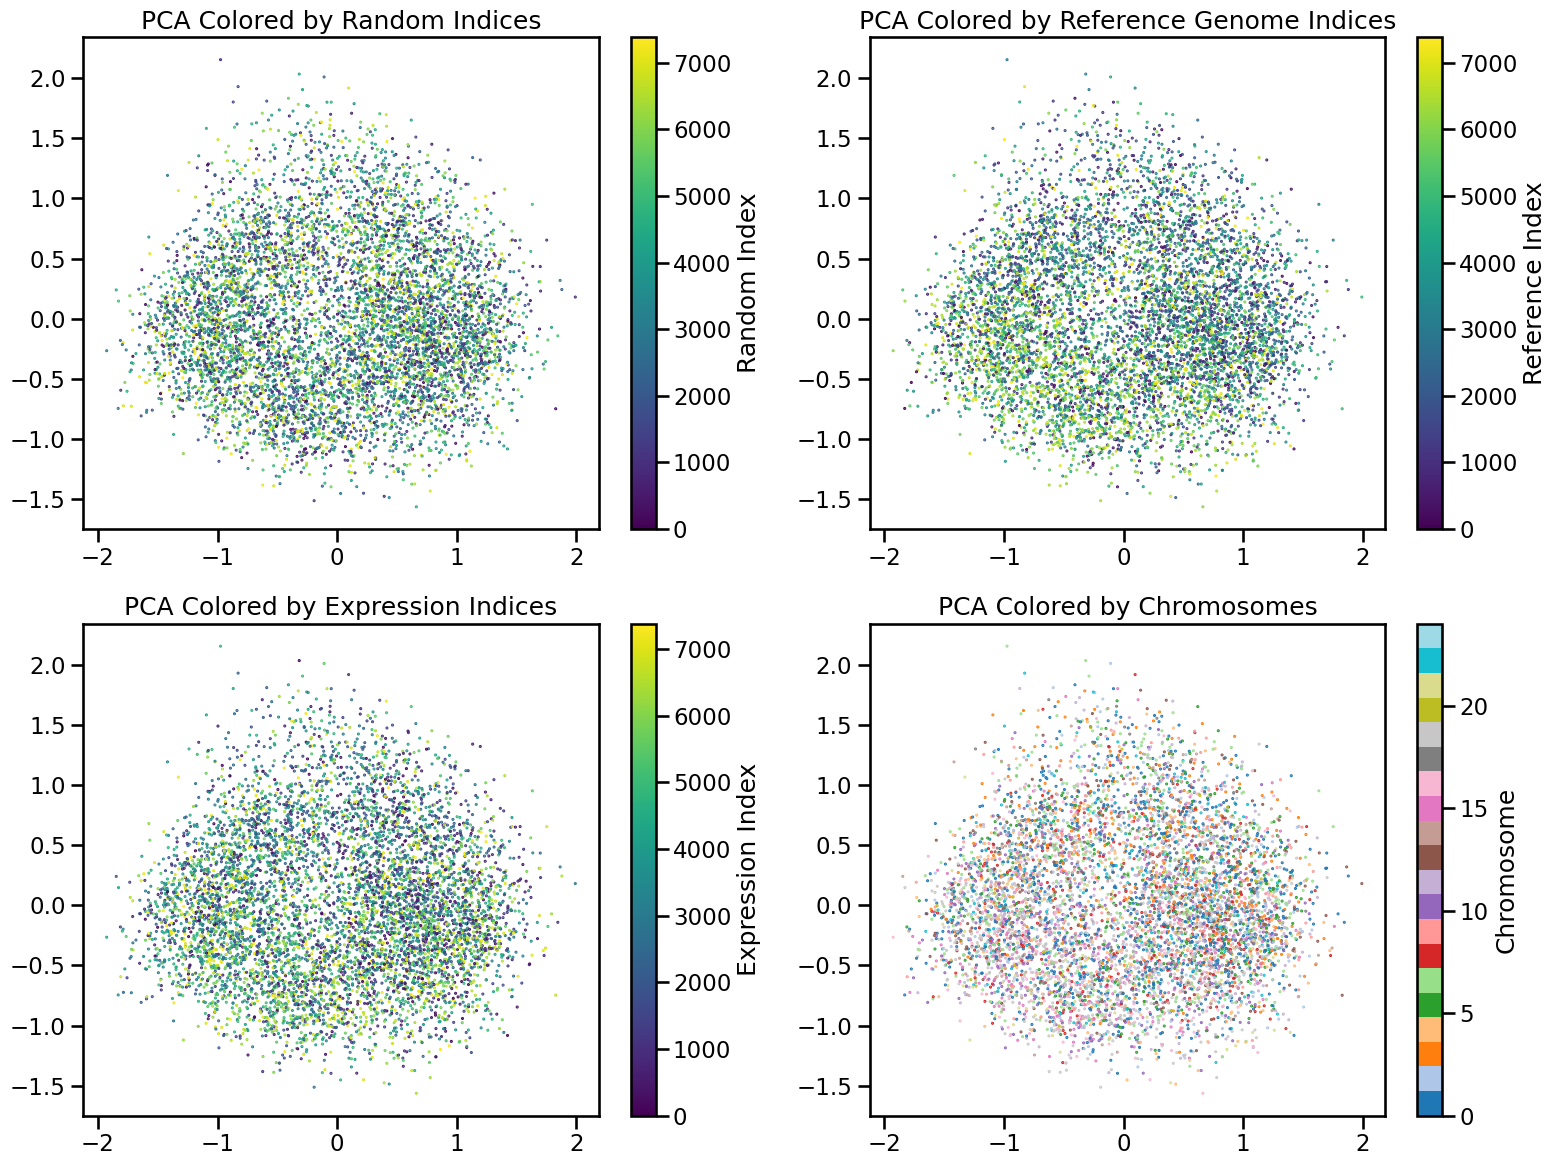

In [51]:
# Import required libraries
from sklearn.decomposition import PCA

# Create PCA embeddings
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(gene_emb)

# Create figure with 4 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot colored by random indices
scatter1 = ax1.scatter(pca_results[:, 0], pca_results[:, 1], s=0.5,
                      c=random_idx, cmap='viridis')
ax1.set_title('PCA Colored by Random Indices')
plt.colorbar(scatter1, ax=ax1, label='Random Index')

# Plot colored by reference genome indices  
scatter2 = ax2.scatter(pca_results[:, 0], pca_results[:, 1], s=0.5,
                      c=ref_idx, cmap='viridis')
ax2.set_title('PCA Colored by Reference Genome Indices')
plt.colorbar(scatter2, ax=ax2, label='Reference Index')

# Plot colored by expression indices
scatter3 = ax3.scatter(pca_results[:, 0], pca_results[:, 1], s=0.5,
                      c=exp_idx, cmap='viridis')
ax3.set_title('PCA Colored by Expression Indices')
plt.colorbar(scatter3, ax=ax3, label='Expression Index')

# Plot colored by chromosome numbers
scatter4 = ax4.scatter(pca_results[:, 0], pca_results[:, 1], s=0.5,
                      c=gene_chromosomes_num, cmap='tab20')
ax4.set_title('PCA Colored by Chromosomes')
plt.colorbar(scatter4, ax=ax4, label='Chromosome')

plt.tight_layout()
plt.show()
